## Harmful Hate Speech Detection
This project aims to detect hateful/harmful comments made online. It follows the Supervised Machine Learning Pipeline and will be implemented into a simple web interface for easy demonstration.

### 1. Import Necessary Libraries
(To be changed)

In [1]:
# %pip install emoji
# %pip install contractions

In [2]:
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import train_test_split
import re
from html import unescape
from emoji import demojize
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

### 2. Load Dataset
Dataset(s) are cleaned and merged in sepereate Python file, however, the contents are not yet processed.

In [3]:
# Load CSV dataset for pre-processing
df = pd.read_csv('combined_data.csv')

random.seed(94)
random.shuffle(df.values)

print(f"Total number of comments: {len(df)}")

labels = []
for label in df['label'].unique():
    labels.append(label)
print(f"Available labels: {labels[0]} (non-hate), {labels[1]} (hate)")

# Print the number of comments per label
for label in labels:
    count = len(df[df['label'] == label])
    print(f"Number of comments with label {label}: {count}")
    
# Balace the dataset
balanced_df = pd.DataFrame(columns=df.columns)
for label in labels:
    label_df = df[df['label'] == label].sample(n=23000, random_state=42)
    balanced_df = pd.concat([balanced_df, label_df])

print(f"\nTotal number of comments after balancing: {len(balanced_df)}")
print(f"Label Distribution: {Counter(balanced_df['label'])}")

Total number of comments: 65891
Available labels: 1 (non-hate), 0 (hate)
Number of comments with label 1: 23113
Number of comments with label 0: 42778

Total number of comments after balancing: 46000
Label Distribution: Counter({1: 23000, 0: 23000})


### 2. Train/Test Split

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['comment'],
    balanced_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['label']
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nTraining set label distribution: {Counter(y_train)}")
print(f"Testing set label distribution: {Counter(y_test)}")


Training set size: 36800
Testing set size: 9200

Training set label distribution: Counter({0: 18400, 1: 18400})
Testing set label distribution: Counter({0: 4600, 1: 4600})


### 3. Data Preprocessing

In [5]:
NEGATION_WORDS = {"no", "not", "nor", "never", "n't"}
STOPWORDS = set(stopwords.words('english')) - NEGATION_WORDS

def expand_contractions(text):
    if not text:
        return ''
    try:
        return contractions.fix(text)
    except Exception:
        return text

def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def preprocess_text(text):
    if text is None:
        return ''
    text = str(text)
    text = unescape(text)	# Decode HTML
    text = demojize(text)     # Convert emoji to text tokens
    text = re.sub(r'http\S+|www\.\S+', ' ', text)	# Remove URLs

    # Remove 'RT' token and user mentions
    text = re.sub(r'\bRT\b', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'@\w+', ' ', text)
    
    text = re.sub(r'#', '', text)    # Remove hashtag symbol but keep the word

    # Expand contractions and normalize repeated chars
    text = expand_contractions(text)
    text = normalize_repeated_chars(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text) 	# Remove digits but keep colons so emoji is preserved
    text = re.sub(r'[^a-z0-9\s:]', ' ', text) 	# Remove most special characters but keep basic punctuation
    text = re.sub(r'\s+', ' ', text).strip() 	# Collapse multiple spaces
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # POS tag
    pos_tags = pos_tag(tokens)
    
    # Lemmatization
    processed_tokens = []
    lemmatizer = WordNetLemmatizer()
    
    for token, tag in pos_tags:
        if token not in STOPWORDS and len(token) > 0:
            lemmatized_token = lemmatizer.lemmatize(token)
            
            processed_tokens.append(lemmatized_token)
            
            # For sentiment-important POS tags, also add POS-tagged version
            sent_pos = set(['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'])
            if tag in sent_pos:  # Adjectives and adverbs
                processed_tokens.append(f"{lemmatized_token}_{tag}")

    return ' '.join(processed_tokens)

# Apply preprocessing to training and testing sets (works if X_train/X_test are pandas Series)
print("Preprocessing training data...")
X_train_processed = [preprocess_text(text) for text in X_train.fillna('').astype(str)]
print("Preprocessing testing data...")
X_test_processed = [preprocess_text(text) for text in X_test.fillna('').astype(str)]

# Display some examples (safe for small training sets)
print("\nExamples of preprocessed comments:")
n_examples = min(3, len(X_train))
sample_indices = random.sample(range(len(X_train)), n_examples)
for i in sample_indices:
    print(f"Original: {X_train.iloc[i]!r}, Label: {y_train.iloc[i]}")
    print(f"    Processed: {X_train_processed[i]}")

Preprocessing training data...
Preprocessing testing data...

Examples of preprocessed comments:
Original: 'jeez, transgender is about as legitimate as fairies and mermaids, imho', Label: 0
    Processed: jeez transgender legitimate legitimate_JJ fairy mermaid imho
Original: 'If you don\'t like, as you say, "sexist pigs", you should take a look at those muslim morons. They\'ll tell you to shut the fuck up and wear the headscarf.', Label: 0
    Processed: not not_RB like say sexist sexist_JJ pig take look muslim muslim_JJ moron tell shut fuck wear headscarf
Original: 'That #BIDEN how Weird he?? like some ??aving Lunatic??in some Weird Terror Movie; with those Creepy Dark Glasses... Like A #Blind #MaGoo ?? yet not so happy and nice!', Label: 1
    Processed: biden weird weird_JJ like aving lunatic lunatic_JJ weird weird_JJ terror movie creepy dark glass like blind magoo yet yet_RB not not_RB happy happy_JJ nice nice_JJ


### 4. Feature Extraction

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Increase features for better sentiment capture
    ngram_range=(1, 2),       # Include both unigrams and bigrams
    min_df=2,                 # Ignore terms that appear in fewer than 2 documents
    max_df=0.95,              # Ignore terms that appear in more than 95% of documents
)
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train_processed)
X_test_vectorized = tfidf_vectorizer.transform(X_test_processed)
print(f"\nNumber of features after TF-IDF vectorization: {X_train_vectorized.shape[1]}")


Number of features after TF-IDF vectorization: 5000


### 5. Model Training

In [9]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
print("Training Logistic Regression model...")
classifier = LogisticRegression(max_iter=1000, random_state=42, C=1.0)

# Convert labels to integers
y_train_int = y_train.astype(int)
classifier.fit(X_train_vectorized, y_train_int)

print("Model training completed.")
print(f"\nNumber of classes: {len(classifier.classes_)}")
print(f"Classes: {classifier.classes_}")

Training Logistic Regression model...
Model training completed.

Number of classes: 2
Classes: [0 1]


In [10]:
# Show most important features
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]

# Get top 10 positive and negative features
top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]

print("\nTop 10 positive features:")
for index in top_positive_indices:
	print(f"  {feature_names[index]}: {coefficients[index]:.4f}")

print("\nTop 10 negative features:")
for index in top_negative_indices:
	print(f"  {feature_names[index]}: {coefficients[index]:.4f}")


Top 10 positive features:
  yankee: 4.6643
  charlie: 3.9860
  son bitch: 3.1977
  bird: 3.0734
  politician: 2.8720
  tory: 2.8239
  computer: 2.5241
  bigot: 2.4520
  not_rb stupid: 2.4372
  n_jj people: 2.3267

Top 10 negative features:
  bitch: -16.5677
  hoe: -11.7575
  pussy: -9.1274
  faggot: -6.2524
  niggah: -4.8683
  black: -4.6116
  retard: -4.5943
  retarded: -4.3479
  fag: -3.8669
  kike: -3.7934


### 7. Model Evaluation


Test Accuracy: 0.7679

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75      4600
           1       0.73      0.85      0.79      4600

    accuracy                           0.77      9200
   macro avg       0.78      0.77      0.77      9200
weighted avg       0.78      0.77      0.77      9200


Confusion Matrix:
[[3157 1443]
 [ 692 3908]]


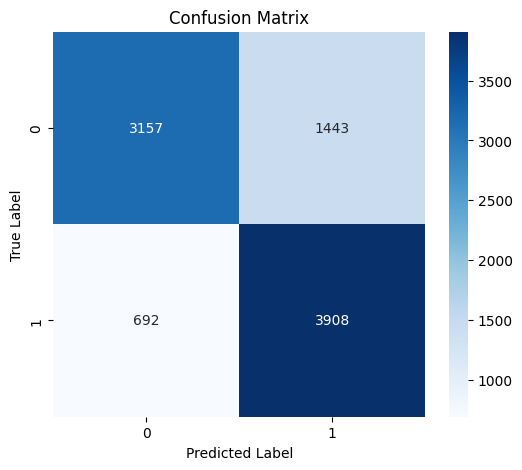

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = classifier.predict(X_test_vectorized)
test_accuracy = accuracy_score(y_test.astype(int), y_pred)

print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test.astype(int), y_pred, target_names=classifier.classes_.astype(str)))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test.astype(int), y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
			xticklabels=classifier.classes_,
			yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 8. Testing Model

In [17]:
custom_comments = [
	"I hate you so much!",
	"I can't stand you!",
	"I love New York City!",
	"You make me sick!",
	"You look pretty!",
	"I wish you would disappear!"
]

for comment in custom_comments:
	processed_comment = preprocess_text(comment)
	vectorized_comment = tfidf_vectorizer.transform([processed_comment])
	prediction = classifier.predict(vectorized_comment)
	probabilities = classifier.predict_proba(vectorized_comment)

	predict_sentiment = 'hate' if classifier.classes_[prediction[0]] == 1 else 'non-hate'
	confidence = probabilities.max()
	
	print(f"\nComment: {comment!r}")
	print(f"  Confidence Scores: {confidence:.3f}")
	print(f"  Predicted Label: {predict_sentiment.title()} (Probability: {probabilities[0][prediction[0]]:.3f})")


Comment: 'I hate you so much!'
  Confidence Scores: 0.548
  Predicted Label: Non-Hate (Probability: 0.548)

Comment: "I can't stand you!"
  Confidence Scores: 0.584
  Predicted Label: Hate (Probability: 0.584)

Comment: 'I love New York City!'
  Confidence Scores: 0.801
  Predicted Label: Hate (Probability: 0.801)

Comment: 'You make me sick!'
  Confidence Scores: 0.661
  Predicted Label: Hate (Probability: 0.661)

Comment: 'You look pretty!'
  Confidence Scores: 0.690
  Predicted Label: Hate (Probability: 0.690)

Comment: 'I wish you would disappear!'
  Confidence Scores: 0.525
  Predicted Label: Non-Hate (Probability: 0.525)
